In [2]:
import argparse
from dataclasses import dataclass
import json
import logging
import math
import os
import random
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

import transformers
import wandb
from tqdm.auto import tqdm, trange


logger = logging.getLogger(__name__)
logging.basicConfig(
    format="%(asctime)s: %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

In [3]:
@dataclass
class CustomArguments(transformers.TrainingArguments):
    sample_train: int = 0
    sample_eval: int = 0
    num_choices: int = 0
    model_name_or_path: str = "asdf"  # this is no longer a TrainingArgument attribute
        
    # python dataclasses cannot have positional attributes in subclass,
    # so give all attributes defaults and then make sure they are changed
    def __post_init__(self):
        if not (self.sample_train * self.sample_eval * self.num_choices) or \
               self.model_name_or_path == "asdf":  # make sure none are still default value
            raise TypeError("__init__ missing required argument(s)")

def get_args():
    """ Set hyperparameters """
    args = CustomArguments(
        output_dir="checkpoint",
        model_name_or_path="roberta-base",
        overwrite_output_dir=True,
        do_train=False,  # Zero shot
        do_eval=True,
        per_device_eval_batch_size=8,
        learning_rate=1e-5,  # Should not matter because not training
        weight_decay=0.1,
        save_total_limit=2,
        seed=123,
        sample_train=200,
        sample_eval=-1,
        num_choices=2,
    )
    
    return args

In [12]:
args = get_args()
'''
"bert-base-uncased"
"distilbert-base-uncased"
"bert-large-uncased"
"bert-large-uncased-whole-word-masking" 
"roberta-large"
"facebook/bart-large"
"t5-large"
"albert-large-v1"
'''

args.model_name_or_path = "albert-large-v1"
args.num_choices = 2
transformers.set_seed(args.seed)
if "t5" in args.model_name_or_path.lower():
    model = transformers.T5ForConditionalGeneration.from_pretrained(args.model_name_or_path).cuda()
    args.per_device_eval_batch_size = 1
    tokenizer = transformers.AutoTokenizer.from_pretrained(args.model_name_or_path)
    tokenizer.mask_token = "<extra_id_0>"
else:
    model = transformers.AutoModelForMaskedLM.from_pretrained(args.model_name_or_path).cuda()
    tokenizer = transformers.AutoTokenizer.from_pretrained(args.model_name_or_path)

In [7]:
tokenizer.encode(" smaller", add_special_tokens=False)

[2735]

In [13]:
print(tokenizer.mask_token)
MASK_ID = tokenizer.encode(tokenizer.mask_token, add_special_tokens=False)
SMALL_ID = tokenizer.encode("smaller", add_special_tokens=False)
LARGE_ID = tokenizer.encode("larger", add_special_tokens=False)
#assert len(SMALL_ID) == 1 and len(LARGE_ID) == 1 and len(MASK_ID) == 1
SMALL_ID = SMALL_ID[0]
LARGE_ID = LARGE_ID[0]
MASK_ID = MASK_ID[0]

if "t5" in args.model_name_or_path.lower():
    LABELS = tokenizer("<extra_id_0> blank <extra_id_1> </s>", add_special_tokens=False, return_tensors="pt")
    LABELS = LABELS.input_ids.cuda()  # from testing, "blank" can be any word and results are the same 

objects = ["nail", "pen", "laptop", "table", "house", "airplane", "city", "sun"]
preds = np.zeros([len(objects), len(objects)])
model.eval()
for i, object1 in enumerate(objects):
    for j, object2 in enumerate(objects):
        if i != j:
            sentence = f"The size of a {object1} is usually much {tokenizer.mask_token} than the size of a {object2} ."
            input_ids = tokenizer(sentence, return_tensors="pt").input_ids.cuda()
            if "t5" not in args.model_name_or_path.lower():
                outputs = model(input_ids=input_ids)
            else:
                outputs = model(input_ids=input_ids, labels=LABELS)
                
            logits = outputs.logits
            
            if "t5" not in args.model_name_or_path.lower():
                MASK_INDEX = input_ids[0].tolist().index(MASK_ID)
            else:
                MASK_INDEX = 1  # TODO: not hardcode
            
#             if logits[0, MASK_INDEX, SMALL_ID] < logits[0, MASK_INDEX, LARGE_ID]:
#                 preds[j][i] = 0
#             else:
#                 preds[j][i] = 2
            preds[j][i] = logits[0, MASK_INDEX, LARGE_ID] - logits[0, MASK_INDEX, SMALL_ID]

[MASK]


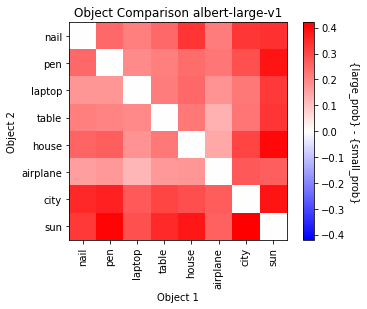

In [14]:
fig, ax = plt.subplots(1, 1)
if -preds.min() > preds.max():
    im = plt.imshow(preds, cmap="bwr", vmin=preds.min(), vmax=-preds.min())
else:
    im = plt.imshow(preds, cmap="bwr", vmin=-preds.max(), vmax=preds.max())
plt.title(f"Object Comparison {args.model_name_or_path}")
plt.xticks(rotation=90)
ax.set_xticks(np.arange(len(objects)))
ax.set_yticks(np.arange(len(objects)))
ax.set_xticklabels(objects)
ax.set_yticklabels(objects)
c = plt.colorbar(im)
c.set_label("{large_prob} - {small_prob}", labelpad=15, rotation=270)
plt.xlabel("Object 1")
plt.ylabel("Object 2")
plt.savefig(f"imgs/{args.model_name_or_path.rsplit('/', 1)[-1]}-object-comparison.jpg", bbox_inches="tight")
plt.show()